In [1]:
using Random, PyPlot, LinearAlgebra, Statistics, DataFrames, FITSIO, FITSTables, CSV, PyCall

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/aw/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
include("get_lamost_spectra.jl")
LogNorm = pyimport("matplotlib.colors").LogNorm
include("../cats/human_readable_names.jl")
include("figures.jl")
include("model.jl")
;

# prep data

In [3]:
Random.seed!(0)
ntest = 100
test_obsids = rand(FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr4v2-stellar.fits.gz").obsid, ntest);

In [4]:
download_lamost_spectra(test_obsids);
test_spectra = []
test_ivar = []
for obsid in test_obsids
    wl, flux, ivar = load_lamost_spectrum(obsid)#; rectify=false)
    push!(test_spectra, flux)
    push!(test_ivar, ivar)
end

;

of 100 spectra, 0 need to be downloaded


In [244]:
include("get_lamost_spectra.jl")
rf_obsids = CSV.read("random.csv").obsid;
download_lamost_spectra(rf_obsids)

rf_spectra = []
rf_ivar = []
for obsid in rf_obsids
    wl, flux, ivar = load_lamost_spectrum(obsid)
    push!(rf_spectra, flux)
    push!(rf_ivar, ivar)
end
;

of 1000 spectra, 987 need to be downloaded


--2020-04-10 13:23:03--  http://dr5.lamost.org/spectrum/fits/554403073?token=
Resolving dr5.lamost.org... 159.226.170.43
Connecting to dr5.lamost.org|159.226.170.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45684 (45K) [application/json]
Saving to: 'LAMOST_spectra/554403073?token='

     0K .......... .......... .......... .......... ....      100% 88.2K=0.5s

2020-04-10 13:23:05 (88.2 KB/s) - 'LAMOST_spectra/554403073?token=' saved [45684/45684]

--2020-04-10 13:23:05--  http://dr5.lamost.org/spectrum/fits/360313126?token=
Resolving dr5.lamost.org... 159.226.170.43
Connecting to dr5.lamost.org|159.226.170.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45646 (45K) [application/json]
Saving to: 'LAMOST_spectra/360313126?token='

     0K .......... .......... .......... .......... ....      100% 86.4K=0.5s

2020-04-10 13:23:06 (86.4 KB/s) - 'LAMOST_spectra/360313126?token=' saved [45646/45646]

--2020-04-10 13:23:06--  http://dr

In [245]:
rf_spectra = transpose(reduce(hcat, rf_spectra));

# compare old and new methods

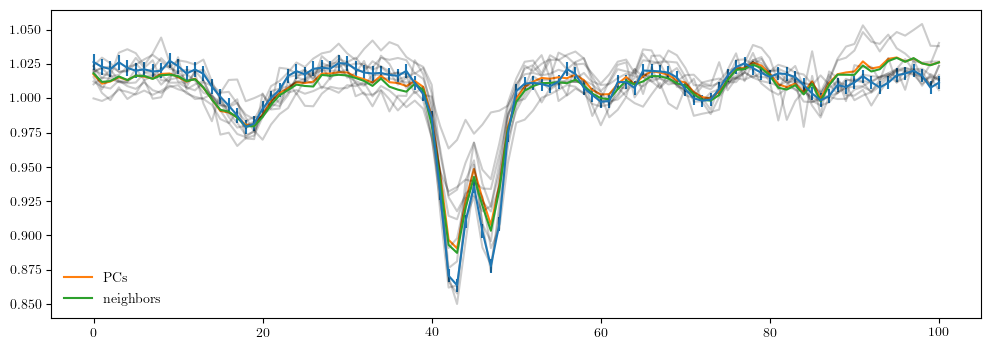

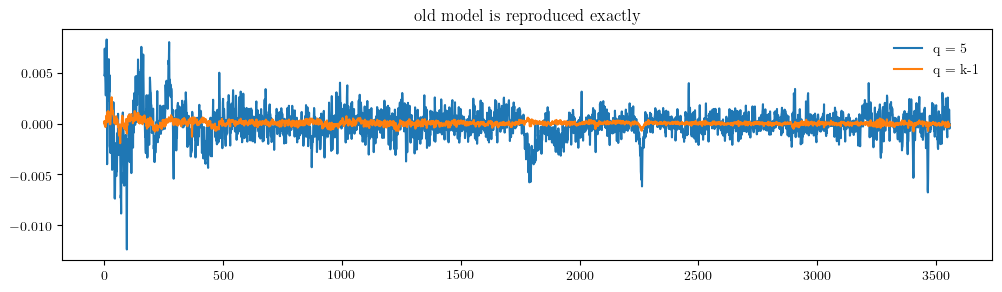

(10, 3559)
(9,)
0.008126435
0.00020232478


PyObject <matplotlib.legend.Legend object at 0x155993320>

In [284]:
maskfrac = 0.1
k = 10
q = 5

rf_set = rf_spectra

f, ivar = rand(collect(zip(test_spectra, test_ivar)))
mask = rand(size(rf_spectra, 2)) .< maskfrac

dists = map(eachrow(rf_spectra)) do rf_spec                                                  
    sum((f[.! mask] .- rf_spec[.! mask]).^2 .* ivar[.! mask])
end 
F = rf_spectra[partialsortperm(dists, 1:k), :]

pf = project_onto_local_manifold(F, f, ivar, mask, q)
mean((pf[mask] - f[mask]).^2)

figure(figsize=(12, 4))
pltmask = 1750:1850
#plot(f[pltmask],  label="data")
errorbar(pltmask .- pltmask[1], f[pltmask], yerr=ivar[pltmask].^(-1/2))
plot(pf[pltmask], label="PCs")
plot(F[:, pltmask]', c="k", alpha=0.2)
println(size(F))
#for spec in 
#    plot(spec[pltmask], c="k", alpha=0.1)
#end

include("model.jl")
μ = mean(F, dims=1)
FF = Matrix((F .- μ)')[:, 1:end-1]
w = calculate_weights(FF, f .- μ[:], ivar.^(-5f-1))
println(size(w))
plot((FF*w + μ[:])[pltmask], label="neighbors")
legend()


figure(figsize=(12, 3))
title("old model is reproduced exactly")
diff = (FF * w + μ[:] - pf) 
plot(diff, label="q = 5")
println(sum(diff.^2))
pf = project_onto_local_manifold(F, f, ivar, mask, k-1)
diff = (FF * w + μ[:] - pf) 
plot(diff, label="q = k-1")
println(sum(diff.^2))
legend()

# parameter study

In [286]:
function MSE(rf_spectra, test_spectra, test_ivar, k, q; maskfrac = 0.1)
    Random.seed!(2)
    
    MSE = map(zip(test_spectra, test_ivar)) do (f, ivar)
        masksize = 100
        npix = size(rf_spectra, 2)
        ind = rand(1 : npix-100)
        mask = ind .<= (1:npix) .<= ind + 100
        
        dists = map(eachrow(rf_spectra)) do rf_spec                                                  
            sum((f[.! mask] .- rf_spec[.! mask]).^2 .* ivar[.! mask])
        end 
        F = rf_spectra[partialsortperm(dists, 1:k), :]
        pf = project_onto_local_manifold(F, f, ivar, mask, q)
        
        #figure(figsize=(12, 4))
        #plot(f[mask])
        #plot(pf[mask])
        #for spec in neighbors
        #    plot(spec[mask], c="k", alpha=0.1)
        #end
        
        mean((pf[mask] - f[mask]).^2 .* ivar[mask])
    end
    mean(MSE)
end
@time MSE(rf_spectra, test_spectra, test_ivar, 10, 5)

  5.162876 seconds (4.10 M allocations: 10.049 GiB, 22.41% gc time)


1.2729446f0

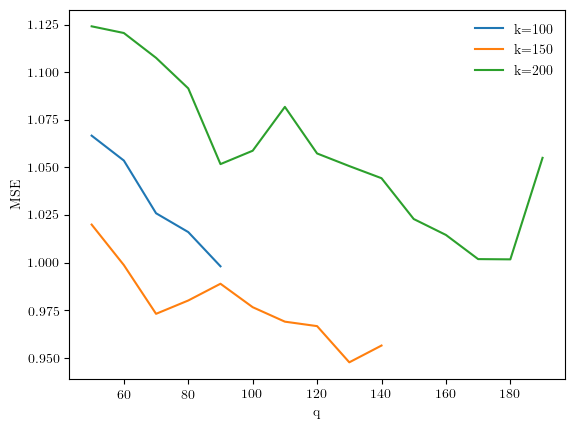

227.113497 seconds (54.44 M allocations: 341.901 GiB, 15.28% gc time)


PyObject <matplotlib.legend.Legend object at 0x14e8f58d0>

In [290]:
@time for k in 100:50:200
    qs = collect(50:10:k-1)
    MSEs = [MSE(rf_spectra, test_spectra, test_ivar, k, q) for q in qs]
    plot(qs, MSEs, label="k=$k")
end
xlabel("q")
ylabel("MSE")
legend()

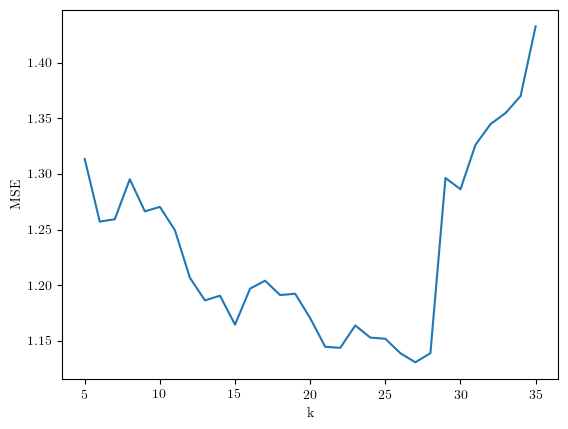

PyObject Text(22.299550986642977, 0.5, 'MSE')

In [293]:
q = 4
ks = 5:35
MSEs = map(ks) do k
    MSE(rf_spectra, test_spectra, test_ivar, k, q)
end
plot(ks, MSEs) 
xlabel("k")
ylabel("MSE")